Neural matrix: 39209 neurons × 118 stimuli
Computing neural PCs...
Plotting all neural PCs...


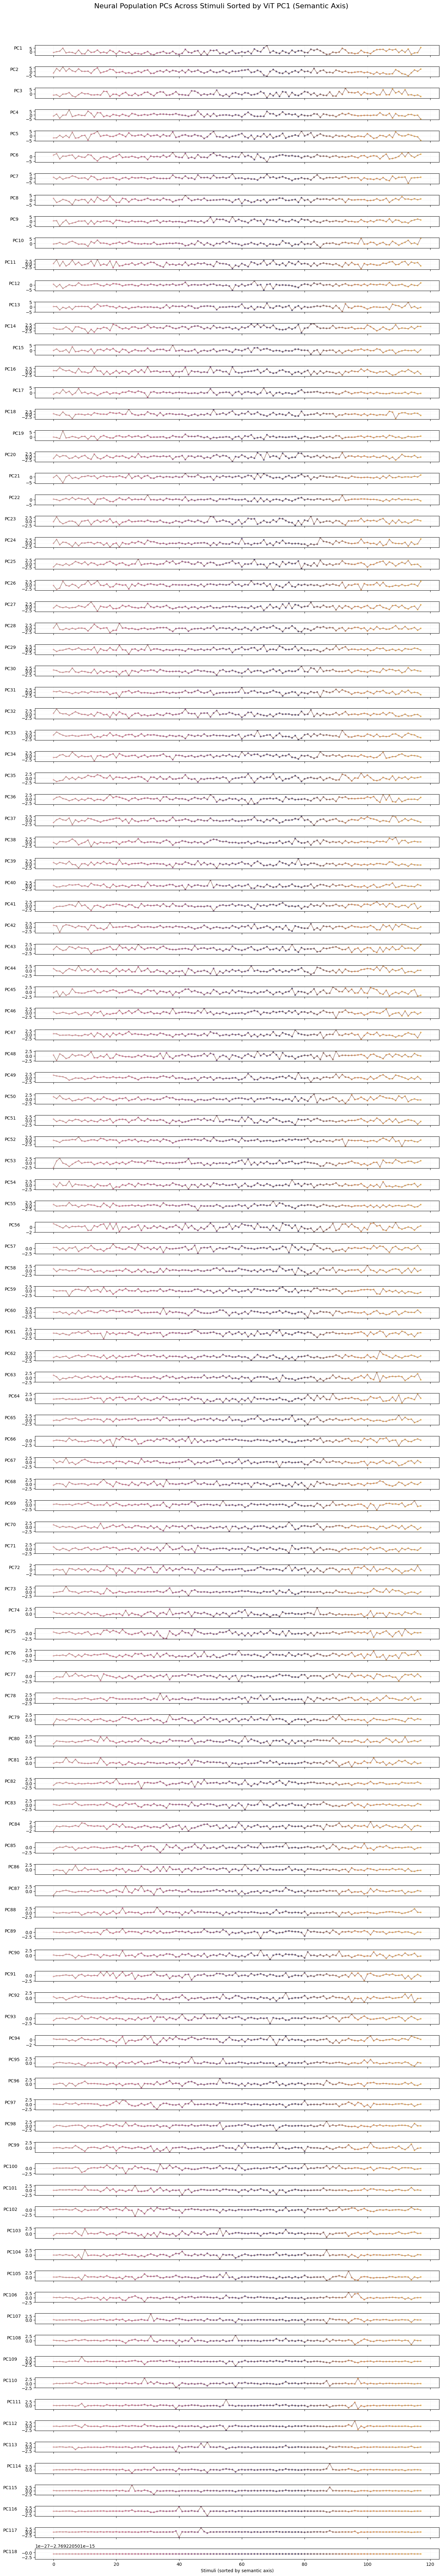

Saved: neural_PCs_sorted_by_ViTPC1.png


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib.colors import LinearSegmentedColormap
import os

# ============================================================
# CONFIGURATION
# ============================================================

VIT_PATH     = '/home/maria/ProjectionSort/data/google_vit-base-patch16-224_embeddings_logits.pkl'
NEURAL_PATH  = '/home/maria/ProjectionSort/data/hybrid_neural_responses_reduced.npy'

SAVE_NAME = "neural_PCs_sorted_by_ViTPC1.png"

# ============================================================
# SUNSET BLISS COLORMAP
# ============================================================

sunset_bliss_colors = [
    (0.99, 0.77, 0.80),
    (0.92, 0.49, 0.68),
    (0.65, 0.34, 0.63),
    (0.34, 0.28, 0.55),
    (0.19, 0.22, 0.44),
    (0.99, 0.66, 0.36),
    (1.00, 0.80, 0.40)
]
sunset_bliss = LinearSegmentedColormap.from_list("sunset_bliss", sunset_bliss_colors)

# ============================================================
# LOAD DATA
# ============================================================

vit = np.load(VIT_PATH, allow_pickle=True)['natural_scenes']  # (118,1000)
R_full = np.load(NEURAL_PATH)                                 # maybe (118,neurons)

# Fix orientation
if R_full.shape[0] == 118:
    R_full = R_full.T   # → (neurons × stimuli)
elif R_full.shape[1] != 118:
    raise ValueError("Neural matrix has unexpected shape:", R_full.shape)

n_neurons, n_stim = R_full.shape
print(f"Neural matrix: {n_neurons} neurons × {n_stim} stimuli")

# ============================================================
# COMPUTE SEMANTIC AXIS (ViT PC1)
# ============================================================

pca_vit = PCA(n_components=1)
vit_pc1 = pca_vit.fit_transform(vit)[:, 0]

semantic_axis = (vit_pc1 - vit_pc1.mean()) / vit_pc1.std()
order_stim = np.argsort(semantic_axis)

# ============================================================
# PCA ON NEURAL RESPONSES
# ============================================================

print("Computing neural PCs...")

pca_neural = PCA(n_components=n_stim)
PCs = pca_neural.fit_transform(R_full.T)   # PCs shape = (118 stimuli × 118 PCs)
PCs = PCs.T                                # (118 PCs × 118 stimuli)

# reorder stimuli by semantic axis
PCs_sorted = PCs[:, order_stim]

# ============================================================
# PLOT ALL 118 PCs (one per row)
# ============================================================

print("Plotting all neural PCs...")

fig, axarr = plt.subplots(
    n_stim, 1,
    figsize=(14, n_stim * 0.7),
    sharex=True,
)

x = np.arange(n_stim)

# color gradient along semantic axis
semantic_colors = sunset_bliss(np.linspace(0, 1, n_stim))

for k in range(n_stim):
    y = PCs_sorted[k]

    axarr[k].scatter(x, y, c=semantic_colors, s=8, alpha=0.9)
    axarr[k].plot(x, y, color=sunset_bliss(0.75), linewidth=1.0)

    axarr[k].set_ylabel(f"PC{k+1}", rotation=0, labelpad=25)
    axarr[k].grid(alpha=0.12)

plt.suptitle(
    "Neural Population PCs Across Stimuli Sorted by ViT PC1 (Semantic Axis)",
    fontsize=16
)
plt.xlabel("Stimuli (sorted by semantic axis)")
plt.tight_layout(rect=[0, 0, 1, 0.97])

plt.savefig(SAVE_NAME, dpi=150)
plt.show()

print(f"Saved: {SAVE_NAME}")


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
import os
from sklearn.decomposition import PCA
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.colors import LinearSegmentedColormap
from PIL import Image
import urllib.request

# ============================================================
# CONFIGURATION
# ============================================================

VIT_PATH     = '/home/maria/ProjectionSort/data/google_vit-base-patch16-224_embeddings_logits.pkl'
NEURAL_PATH  = '/home/maria/ProjectionSort/data/hybrid_neural_responses_reduced.npy'
IMAGE_DIR    = '/home/maria/ProjectionSort/data/images/images'

FPS  = 0.75
ZOOM = 0.6

# ============================================================
# SUNSET BLISS COLORMAP
# ============================================================

sunset_bliss_colors = [
    (0.99, 0.77, 0.80),
    (0.92, 0.49, 0.68),
    (0.65, 0.34, 0.63),
    (0.34, 0.28, 0.55),
    (0.19, 0.22, 0.44),
    (0.99, 0.66, 0.36),
    (1.00, 0.80, 0.40)
]

sunset_bliss = LinearSegmentedColormap.from_list("sunset_bliss", sunset_bliss_colors)

# ============================================================
# LOAD DATA
# ============================================================

print("Loading data...")

vit = np.load(VIT_PATH, allow_pickle=True)['natural_scenes']
R_full = np.load(NEURAL_PATH)

# Ensure (neurons × stimuli)
if R_full.shape[0] == 118:
    print("Transposing R_full (stim × neurons → neurons × stim)")
    R_full = R_full.T

n_neurons, n_stim = R_full.shape
print("Neural matrix:", R_full.shape)

# ============================================================
# SEMANTIC AXIS (ViT PC1)
# ============================================================

pca_vit = PCA(n_components=1)
vit_pc1 = pca_vit.fit_transform(vit)[:, 0]   # length 118

v = (vit_pc1 - vit_pc1.mean()) / vit_pc1.std()
order_stim = np.argsort(v)

# ============================================================
# PCA ON NEURAL RESPONSES
# ============================================================

print("Computing neural PCs...")

pca_neural = PCA(n_components=n_stim)
PCs = pca_neural.fit_transform(R_full.T)  # shape = (stimuli × PCs)
PCs = PCs.T                               # → (PCs × stimuli)

PCs_sorted = PCs[:, order_stim]           # reorder stimuli

# ============================================================
# GIF OUTPUT
# ============================================================

os.makedirs("frames_pcs", exist_ok=True)
frame_paths = []

ymin = PCs_sorted.min()
ymax = PCs_sorted.max()
YTOP = ymax * 1.3   # room for thumbnails

# ============================================================
# MAIN LOOP — ONE PC PER FRAME
# ============================================================

# ============================================================
# MAIN LOOP — ONE PC PER FRAME (WITH VARIANCE EXPLAINED)
# ============================================================

print("Generating frames (one PC per frame)...")

var_exp = pca_neural.explained_variance_ratio_  # shape (n_stim,)

for pc_idx in range(n_stim):

    y = PCs_sorted[pc_idx]
    ve = var_exp[pc_idx] * 100  # percentage

    plt.figure(figsize=(12, 6))
    plt.ylim(ymin, YTOP)
    plt.xlim(0, n_stim - 1)

    # Sunset Bliss gradient scatter
    colors = sunset_bliss(np.linspace(0, 1, n_stim))
    plt.scatter(np.arange(n_stim), y, c=colors, s=24, alpha=0.9)

    # Sunset Bliss line
    plt.plot(np.arange(n_stim), y, color=sunset_bliss(0.75), linewidth=1.3)

    # ===== NEW TITLE WITH VARIANCE EXPLAINED =====
    plt.title(
        f"Neural PC {pc_idx+1} — Variance Explained: {ve:.2f}%\n"
        f"Activity Across Stimuli Sorted by ViT PC1",
        fontsize=14
    )

    plt.xlabel("Semantic Axis (ViT PC1 Sorted)")
    plt.ylabel("PC Amplitude")
    plt.grid(alpha=0.15, color=sunset_bliss(0.2))

    # --------------------------------------------------------
    # TOP-3 MOST ACTIVATING STIMULI (GRAYSCALE IMAGES)
    # --------------------------------------------------------
    top3_local = np.argsort(y)[-3:]
    top3_global = order_stim[top3_local]

    for local_x, global_idx in zip(top3_local, top3_global):

        base = f"{IMAGE_DIR}/scene_{global_idx:03d}"
        if os.path.exists(base + ".png"):
            img_path = base + ".png"
        elif os.path.exists(base + ".jpg"):
            img_path = base + ".jpg"
        else:
            print("Missing:", base)
            continue

        img = Image.open(img_path).convert("L")   # grayscale
        im = OffsetImage(img, zoom=ZOOM, cmap="gray")

        ab = AnnotationBbox(
            im,
            (local_x, ymax * 1.1),
            xycoords='data',
            frameon=False
        )
        plt.gca().add_artist(ab)

    # SAVE FRAME
    frame_file = f"frames_pcs/frame_{pc_idx:05d}.png"
    plt.savefig(frame_file, dpi=120)
    plt.close()

    frame_paths.append(frame_file)

    if pc_idx % 10 == 0:
        print(f"{pc_idx}/{n_stim} PCs processed...")


# ============================================================
# GENERATE GIF
# ============================================================

print("Creating GIF...")

images = [imageio.imread(fp) for fp in frame_paths]
imageio.mimsave("neural_PCs_semantic_sorted.gif", images, fps=FPS)

print("\nGIF saved as: neural_PCs_semantic_sorted.gif")


Loading data...
Neural matrix: (39209, 118)
Computing neural PCs...
Generating frames (one PC per frame)...
0/118 PCs processed...
10/118 PCs processed...
20/118 PCs processed...
30/118 PCs processed...
40/118 PCs processed...
50/118 PCs processed...
60/118 PCs processed...
70/118 PCs processed...
80/118 PCs processed...
90/118 PCs processed...
100/118 PCs processed...
110/118 PCs processed...
Creating GIF...


/tmp/ipykernel_1787670/1622320492.py:172: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [imageio.imread(fp) for fp in frame_paths]



GIF saved as: neural_PCs_semantic_sorted.gif


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
import os
from sklearn.decomposition import PCA
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.colors import LinearSegmentedColormap
from PIL import Image

# ============================================================
# CONFIGURATION
# ============================================================

VIT_PATH     = '/home/maria/ProjectionSort/data/google_vit-base-patch16-224_embeddings_logits.pkl'
NEURAL_PATH  = '/home/maria/ProjectionSort/data/hybrid_neural_responses_reduced.npy'
IMAGE_DIR    = '/home/maria/ProjectionSort/data/images/images'
IMAGENET_LABELS = '/home/maria/ProjectionSort/data/imagenet_classes.txt'

FPS  = 0.75
ZOOM = 0.6

# ============================================================
# LOAD IMAGENET CLASS NAMES
# ============================================================

with open(IMAGENET_LABELS, 'r') as f:
    imagenet_names = [line.strip() for line in f.readlines()]
print("Loaded ImageNet labels:", len(imagenet_names))

# ============================================================
# SUNSET BLISS COLORMAP
# ============================================================

sunset_bliss_colors = [
    (0.99, 0.77, 0.80),
    (0.92, 0.49, 0.68),
    (0.65, 0.34, 0.63),
    (0.34, 0.28, 0.55),
    (0.19, 0.22, 0.44),
    (0.99, 0.66, 0.36),
    (1.00, 0.80, 0.40)
]

sunset_bliss = LinearSegmentedColormap.from_list("sunset_bliss", sunset_bliss_colors)

# ============================================================
# LOAD DATA
# ============================================================

print("Loading data...")

vit = np.load(VIT_PATH, allow_pickle=True)['natural_scenes']
R_full = np.load(NEURAL_PATH)

# Ensure (neurons × stimuli)
if R_full.shape[0] == 118:
    print("Transposing R_full (stim × neurons → neurons × stim)")
    R_full = R_full.T

n_neurons, n_stim = R_full.shape
print("Neural matrix:", R_full.shape)

# ============================================================
# GET IMAGENET TOP-1 LABELS PER STIMULUS
# ============================================================

logit_argmax = np.argmax(vit, axis=1)  # (118,)
imagenet_labels = [imagenet_names[i] for i in logit_argmax]

# ============================================================
# SEMANTIC AXIS (ViT PC1)
# ============================================================

pca_vit = PCA(n_components=1)
vit_pc1 = pca_vit.fit_transform(vit)[:, 0]  # length 118

v = (vit_pc1 - vit_pc1.mean()) / vit_pc1.std()
order_stim = np.argsort(v)

labels_sorted = [imagenet_labels[i] for i in order_stim]

# ============================================================
# PCA ON NEURAL RESPONSES
# ============================================================

print("Computing neural PCs...")

pca_neural = PCA(n_components=n_stim)
PCs = pca_neural.fit_transform(R_full.T)  # (stim x PC)
PCs = PCs.T                               # (PC x stim)
PCs_sorted = PCs[:, order_stim]

var_exp = pca_neural.explained_variance_ratio_

# ============================================================
# GIF OUTPUT
# ============================================================

os.makedirs("frames_pcs", exist_ok=True)
frame_paths = []

ymin = PCs_sorted.min()
ymax = PCs_sorted.max()
YTOP = ymax * 1.3   # room for thumbnails

# ============================================================
# MAIN LOOP — PC FRAMES
# ============================================================

print("Generating frames (one PC per frame)...")

for pc_idx in range(n_stim):

    y = PCs_sorted[pc_idx]
    ve = var_exp[pc_idx] * 100

    plt.figure(figsize=(14, 6))
    plt.ylim(ymin, YTOP)
    plt.xlim(0, n_stim - 1)

    # scatter + line
    colors = sunset_bliss(np.linspace(0, 1, n_stim))
    xs = np.arange(n_stim)

    plt.scatter(xs, y, c=colors, s=24, alpha=0.9)
    plt.plot(xs, y, color=sunset_bliss(0.75), linewidth=1.3)

    # TITLE
    plt.title(
        f"Neural PC {pc_idx+1} — Variance Explained: {ve:.2f}%\n"
        f"Stimuli Sorted by ViT PC1 Semantic Axis",
        fontsize=15
    )

    plt.ylabel("PC Amplitude")
    plt.grid(alpha=0.15, color=sunset_bliss(0.2))

    # ======================================================
    # X-AXIS LABELS (IMAGENET NAMES)
    # ======================================================

    # choose every 6th label to avoid clutter
    tick_positions = np.arange(0, n_stim, 6)
    tick_labels = [labels_sorted[i] for i in tick_positions]

    plt.xticks(tick_positions, tick_labels, rotation=70, fontsize=7)

    # ======================================================
    # TOP-3 IMAGE THUMBNAILS IN GRAYSCALE
    # ======================================================

    top3_local = np.argsort(y)[-3:]
    top3_global = order_stim[top3_local]

    for local_x, global_idx in zip(top3_local, top3_global):

        base = f"{IMAGE_DIR}/scene_{global_idx:03d}"
        if os.path.exists(base + ".png"):
            img_path = base + ".png"
        elif os.path.exists(base + ".jpg"):
            img_path = base + ".jpg"
        else:
            print("Missing:", base)
            continue

        img = Image.open(img_path).convert("L")
        im = OffsetImage(img, zoom=ZOOM, cmap="gray")

        ab = AnnotationBbox(
            im,
            (local_x, ymax * 1.1),
            xycoords='data',
            frameon=False
        )
        plt.gca().add_artist(ab)

    # SAVE FRAME
    frame_file = f"frames_pcs/frame_{pc_idx:05d}.png"
    plt.savefig(frame_file, dpi=120, bbox_inches="tight")
    plt.close()

    frame_paths.append(frame_file)

    if pc_idx % 10 == 0:
        print(f"{pc_idx}/{n_stim} PCs processed...")

# ============================================================
# GENERATE GIF
# ============================================================

print("Creating GIF...")

images = [imageio.imread(fp) for fp in frame_paths]
imageio.mimsave("neural_PCs_semantic_sorted.gif", images, fps=FPS)

print("\nGIF saved as: neural_PCs_semantic_sorted.gif")


Loaded ImageNet labels: 1000
Loading data...
Neural matrix: (39209, 118)
Computing neural PCs...
Generating frames (one PC per frame)...
0/118 PCs processed...
10/118 PCs processed...
20/118 PCs processed...
30/118 PCs processed...
40/118 PCs processed...
50/118 PCs processed...
60/118 PCs processed...
70/118 PCs processed...
80/118 PCs processed...
90/118 PCs processed...
100/118 PCs processed...
110/118 PCs processed...
Creating GIF...


/tmp/ipykernel_1787670/153374742.py:193: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [imageio.imread(fp) for fp in frame_paths]


ValueError: all input arrays must have the same shape

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
import os
from sklearn.decomposition import PCA
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.colors import LinearSegmentedColormap
from PIL import Image

# ============================================================
# CONFIGURATION
# ============================================================

VIT_PATH     = '/home/maria/ProjectionSort/data/google_vit-base-patch16-224_embeddings_logits.pkl'
NEURAL_PATH  = '/home/maria/ProjectionSort/data/hybrid_neural_responses_reduced.npy'
IMAGE_DIR    = '/home/maria/ProjectionSort/data/images/images'
IMAGENET_LABELS = '/home/maria/ProjectionSort/data/imagenet_classes.txt'

FPS  = 0.75
ZOOM = 0.6

# ============================================================
# LOAD IMAGENET CLASS NAMES
# ============================================================

with open(IMAGENET_LABELS, 'r') as f:
    imagenet_names = [line.strip() for line in f.readlines()]
print("Loaded ImageNet labels:", len(imagenet_names))

# ============================================================
# COLOR MAPS
# ============================================================

sunset_bliss_colors = [
    (0.99, 0.77, 0.80),
    (0.92, 0.49, 0.68),
    (0.65, 0.34, 0.63),
    (0.34, 0.28, 0.55),
    (0.19, 0.22, 0.44),
    (0.99, 0.66, 0.36),
    (1.00, 0.80, 0.40)
]
sunset_bliss = LinearSegmentedColormap.from_list("sunset_bliss", sunset_bliss_colors)

forest_breeze_colors = [
    (0.80, 0.95, 0.85),
    (0.60, 0.85, 0.70),
    (0.30, 0.70, 0.55),
    (0.10, 0.50, 0.45),
    (0.05, 0.35, 0.30)
]
forest_breeze = LinearSegmentedColormap.from_list("forest_breeze", forest_breeze_colors)

# ============================================================
# LOAD DATA
# ============================================================

print("Loading data...")

vit = np.load(VIT_PATH, allow_pickle=True)['natural_scenes']
R_full = np.load(NEURAL_PATH)

# Ensure (neurons × stimuli)
if R_full.shape[0] == 118:
    print("Transposing R_full (stim × neurons → neurons × stim)")
    R_full = R_full.T

n_neurons, n_stim = R_full.shape
print("Neural matrix:", R_full.shape)

# ============================================================
# IMAGENET PREDICTED LABELS
# ============================================================

logit_argmax = np.argmax(vit, axis=1)
imagenet_labels = [imagenet_names[i] for i in logit_argmax]

# ============================================================
# SEMANTIC AXIS (ViT PC1)
# ============================================================

pca_vit = PCA(n_components=1)
vit_pc1 = pca_vit.fit_transform(vit)[:, 0]

v = (vit_pc1 - vit_pc1.mean()) / vit_pc1.std()
order_stim = np.argsort(v)

labels_sorted = [imagenet_labels[i] for i in order_stim]

# ============================================================
# PCA ON NEURAL RESPONSES
# ============================================================

print("Computing neural PCs...")

pca_neural = PCA(n_components=n_stim)
PCs = pca_neural.fit_transform(R_full.T)   # (stim × PC)
PCs = PCs.T                                 # (PC × stim)

PCs_sorted = PCs[:, order_stim]
var_exp = pca_neural.explained_variance_ratio_

# ============================================================
# GIF OUTPUT
# ============================================================

os.makedirs("frames_pcs", exist_ok=True)
frame_paths = []

ymin = PCs_sorted.min()
ymax = PCs_sorted.max()
YTOP = ymax * 1.3

# ============================================================
# MAIN LOOP
# ============================================================

print("Generating frames...")

for pc_idx in range(n_stim):

    y = PCs_sorted[pc_idx]
    ve = var_exp[pc_idx] * 100

    plt.figure(figsize=(14, 6))
    xs = np.arange(n_stim)

    plt.ylim(ymin, YTOP)
    plt.xlim(0, n_stim - 1)

    # scatter
    colors = sunset_bliss(np.linspace(0, 1, n_stim))
    plt.scatter(xs, y, c=colors, s=24, alpha=0.9)

    # green line
    plt.plot(xs, y, color=forest_breeze(0.6), linewidth=1.8)

    # title
    plt.title(
        f"Neural PC {pc_idx+1} — Variance Explained: {ve:.2f}%\n"
        f"Stimuli Sorted by ViT PC1 Semantic Axis",
        fontsize=15
    )

    plt.ylabel("PC Amplitude")
    plt.grid(alpha=0.15, color=sunset_bliss(0.2))

    # X-axis ticks (ImageNet labels)
    tick_positions = np.arange(0, n_stim, 6)
    tick_labels = [labels_sorted[i] for i in tick_positions]
    plt.xticks(tick_positions, tick_labels, rotation=70, fontsize=7)

    # --------------------------------------------------------
    # TOP-3 THUMBNAILS (GRAYSCALE)
    # --------------------------------------------------------

    top3_local = np.argsort(y)[-3:]
    top3_global = order_stim[top3_local]

    for local_x, global_idx in zip(top3_local, top3_global):

        base = f"{IMAGE_DIR}/scene_{global_idx:03d}"
        if os.path.exists(base + ".png"):
            img_path = base + ".png"
        elif os.path.exists(base + ".jpg"):
            img_path = base + ".jpg"
        else:
            continue

        img = Image.open(img_path).convert("L")
        im = OffsetImage(img, zoom=ZOOM, cmap="gray")

        ab = AnnotationBbox(
            im,
            (local_x, ymax * 1.1),
            xycoords='data',
            frameon=False
        )
        plt.gca().add_artist(ab)

    # SAVE FRAME (NO bbox_inches!)
    frame_file = f"frames_pcs/frame_{pc_idx:05d}.png"
    plt.savefig(frame_file, dpi=120)
    plt.close()

    frame_paths.append(frame_file)

    if pc_idx % 10 == 0:
        print(f"{pc_idx}/{n_stim} PCs processed...")

# ============================================================
# GIF CREATION
# ============================================================

print("Creating GIF...")

images = [imageio.v2.imread(fp) for fp in frame_paths]
imageio.mimsave("neural_PCs_semantic_sorted.gif", images, fps=FPS)

print("\nGIF saved as: neural_PCs_semantic_sorted.gif")


Loaded ImageNet labels: 1000
Loading data...
Neural matrix: (39209, 118)
Computing neural PCs...
Generating frames...
0/118 PCs processed...
10/118 PCs processed...
20/118 PCs processed...
30/118 PCs processed...
40/118 PCs processed...
50/118 PCs processed...
60/118 PCs processed...
70/118 PCs processed...
80/118 PCs processed...
90/118 PCs processed...
100/118 PCs processed...
110/118 PCs processed...
Creating GIF...

GIF saved as: neural_PCs_semantic_sorted.gif


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
import os
from sklearn.decomposition import PCA
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.colors import LinearSegmentedColormap
from PIL import Image
import urllib.request

# ============================================================
# CONFIGURATION
# ============================================================

VIT_PATH     = '/home/maria/ProjectionSort/data/google_vit-base-patch16-224_embeddings_logits.pkl'
NEURAL_PATH  = '/home/maria/ProjectionSort/data/hybrid_neural_responses_reduced.npy'
IMAGE_DIR    = '/home/maria/ProjectionSort/data/images/images'

FPS  = 0.75
ZOOM = 0.6

# ============================================================
# LOAD IMAGENET CLASS NAMES
# ============================================================

if not os.path.exists("imagenet_classes.txt"):
    urllib.request.urlretrieve(
        "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt",
        "imagenet_classes.txt"
    )

with open("imagenet_classes.txt", "r") as f:
    imagenet_classes = [line.strip() for line in f.readlines()]


# shortening rule (exact same as neuron script)
def shorten(label):
    return label.split(",")[0].split(" ")[0][:12]


# ============================================================
# COLOR MAPS
# ============================================================

sunset_bliss_colors = [
    (0.99, 0.77, 0.80),
    (0.92, 0.49, 0.68),
    (0.65, 0.34, 0.63),
    (0.34, 0.28, 0.55),
    (0.19, 0.22, 0.44),
    (0.99, 0.66, 0.36),
    (1.00, 0.80, 0.40)
]
sunset_bliss = LinearSegmentedColormap.from_list("sunset_bliss", sunset_bliss_colors)

forest_breeze_colors = [
    (0.80, 0.95, 0.85),
    (0.60, 0.85, 0.70),
    (0.30, 0.70, 0.55),
    (0.10, 0.50, 0.45),
    (0.05, 0.35, 0.30)
]
forest_breeze = LinearSegmentedColormap.from_list("forest_breeze", forest_breeze_colors)

# ============================================================
# LOAD DATA
# ============================================================

print("Loading data...")

vit = np.load(VIT_PATH, allow_pickle=True)['natural_scenes']
R_full = np.load(NEURAL_PATH)

# ensure (neurons × stim)
if R_full.shape[0] == 118:
    print("Matrix is (stim × neurons) → transposing")
    R_full = R_full.T

n_neurons, n_stim = R_full.shape
print("Neural matrix:", R_full.shape)


# ============================================================
# IMAGE NET LABELS FOR EACH STIMULUS (EXACT SAME PROCESS)
# ============================================================

vit_top_idx = np.argmax(vit, axis=1)
vit_top_classes = np.array([imagenet_classes[i] for i in vit_top_idx])

short_labels = np.array([shorten(lbl) for lbl in vit_top_classes])


# ============================================================
# SEMANTIC AXIS (ViT PC1)
# ============================================================

pca_vit = PCA(n_components=1)
vit_pc1 = pca_vit.fit_transform(vit)[:, 0]

v = (vit_pc1 - vit_pc1.mean()) / vit_pc1.std()
order_stim = np.argsort(v)

# sort the labels
short_labels_sorted = short_labels[order_stim]


# ============================================================
# PCA ON NEURAL RESPONSES
# ============================================================

print("Computing neural PCs...")

pca_neural = PCA(n_components=n_stim)
PCs = pca_neural.fit_transform(R_full.T)  # (stim × PC)
PCs = PCs.T                               # (PC × stim)
PCs_sorted = PCs[:, order_stim]

var_exp = pca_neural.explained_variance_ratio_

# ============================================================
# GIF OUTPUT
# ============================================================

os.makedirs("frames_pcs", exist_ok=True)
frame_paths = []

ymin = PCs_sorted.min()
ymax = PCs_sorted.max()
YTOP = ymax * 1.3


# ============================================================
# MAIN LOOP — PC FRAMES
# ============================================================

print("Generating frames...")

for pc_idx in range(n_stim):

    y = PCs_sorted[pc_idx]
    ve = var_exp[pc_idx] * 100

    plt.figure(figsize=(14, 6))
    xs = np.arange(n_stim)

    plt.ylim(ymin, YTOP)
    plt.xlim(0, n_stim - 1)

    # scatter
    colors = sunset_bliss(np.linspace(0, 1, n_stim))
    plt.scatter(xs, y, c=colors, s=24, alpha=0.9)

    # line
    plt.plot(xs, y, color=forest_breeze(0.6), linewidth=1.8)

    # title
    plt.title(
        f"Neural PC {pc_idx+1} — Variance Explained: {ve:.2f}%\n"
        f"Stimuli Sorted by ViT PC1 Semantic Axis",
        fontsize=15
    )

    plt.ylabel("PC Amplitude")
    plt.grid(alpha=0.15)

    # X-axis: exact same labels as your neuron script
    xticks = np.linspace(0, n_stim - 1, 10, dtype=int)
    plt.xticks(xticks, short_labels_sorted[xticks], rotation=45, fontsize=8)

    # --------------------------------------------------------
    # TOP-3 IMAGES (GRAYSCALE)
    # --------------------------------------------------------

    top3_local = np.argsort(y)[-3:]
    top3_global = order_stim[top3_local]

    for local_x, global_idx in zip(top3_local, top3_global):

        base = f"{IMAGE_DIR}/scene_{global_idx:03d}"
        if os.path.exists(base + ".png"):
            img_path = base + ".png"
        elif os.path.exists(base + ".jpg"):
            img_path = base + ".jpg"
        else:
            continue

        img = Image.open(img_path).convert("L")
        im = OffsetImage(img, zoom=ZOOM, cmap="gray")

        ab = AnnotationBbox(
            im,
            (local_x, ymax * 1.1),
            xycoords='data',
            frameon=False
        )
        plt.gca().add_artist(ab)

    # save frame (NO bbox_inches!)
    frame_file = f"frames_pcs/frame_{pc_idx:05d}.png"
    plt.savefig(frame_file, dpi=120)
    plt.close()

    frame_paths.append(frame_file)

    if pc_idx % 10 == 0:
        print(f"{pc_idx}/{n_stim} PCs processed...")

# ============================================================
# GENERATE GIF
# ============================================================

print("Creating GIF...")

images = [imageio.v2.imread(fp) for fp in frame_paths]
imageio.mimsave("neural_PCs_semantic_sorted.gif", images, fps=FPS)

print("\nGIF saved as: neural_PCs_semantic_sorted.gif")


Loading data...
Neural matrix: (39209, 118)
Computing neural PCs...
Generating frames...
0/118 PCs processed...
10/118 PCs processed...
20/118 PCs processed...
30/118 PCs processed...
40/118 PCs processed...
50/118 PCs processed...
60/118 PCs processed...
70/118 PCs processed...
80/118 PCs processed...
90/118 PCs processed...
100/118 PCs processed...
110/118 PCs processed...
Creating GIF...

GIF saved as: neural_PCs_semantic_sorted.gif
